# Neural networks with PyTorch

Next I'll show you how to build a neural network with PyTorch.

## 1. Load Data

In [1]:
# Import things like usual

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. 

To get the training and test datasets, we need to use:
1. `datasets` module from `torchvision` package
2. `transforms` module from `torchvision` package
2. `DataLoader` class from `torch.utils.data` package

The detail about is explained in part 7 - Loading Image Data.

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

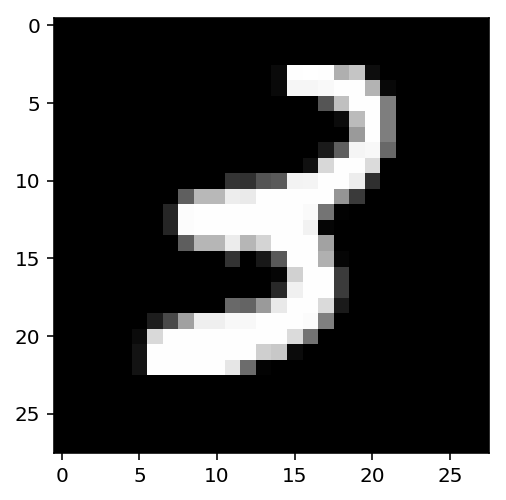

In [8]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## 2. Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image. 

<img src="assets/mlp_mnist.png" width=600px>

> To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. From now on, I will refer to it as `nn.module`. Multiple `nn.Module` objects can be strung together to form a bigger `nn.Module` object, which is how we can implement a neural network using many layers. In fact, `nn.Module` can be used to represent an arbitrary function $f$ in PyTorch.

The `nn.Module` class has two methods that you have to override.

> 1. `__init__` function. This function is invoked when you create an instance of the `nn.Module`. Here you will define layers of the network and specify the various parameters of defined layer such as filters, kernel size for a convolutional layer, dropout probability for the dropout layer.

> 2. `forward` function. The class needs to include a `forward` function that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. This function doesn't need to be explicitly called, and can be run by just calling the `nn.Module` instance like a function with the input as it's argument.

> The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. 

Below are a few different commonly used activation functions.

<img src="assets/activation.png" width=700px>

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [9]:
from torch import nn
from torch import optim
import torch.nn.functional as F

You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

In [10]:
class Network(nn.Module):  # extends class nn.Module
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):   # required for forward passing the input through the network to generate outputs
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        print('fc1', x.shape)
        x = F.relu(x)
        x = self.fc2(x)
        print('fc2', x.shape)
        x = F.relu(x)
        x = self.fc3(x)
        print('fc3', x.shape)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are **automatically initialized** for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [11]:
print(model.fc1.weight)
print(model.fc1.bias)

print(model.fc1.weight.requires_grad)
print(model.fc1.bias.requires_grad)

Parameter containing:
tensor([[-1.2919e-04,  1.8027e-02, -2.4070e-02,  ...,  2.3192e-02,
          7.6343e-04, -2.6149e-02],
        [ 2.7070e-03, -3.3910e-02,  1.3599e-02,  ..., -8.5449e-03,
         -2.1471e-02, -1.3953e-02],
        [ 1.3540e-02,  3.4468e-02,  1.4013e-02,  ...,  2.1902e-02,
          2.9378e-02,  2.6746e-02],
        ...,
        [ 3.2217e-02,  7.6811e-03, -2.6680e-02,  ..., -3.1356e-02,
          7.6893e-03, -3.2188e-02],
        [ 2.3533e-02, -3.1775e-02,  4.9805e-03,  ...,  1.2597e-02,
          1.7382e-02,  5.5698e-03],
        [ 6.4645e-05, -7.6523e-03,  1.7911e-02,  ..., -3.5051e-02,
          2.2018e-03, -2.9897e-02]])
Parameter containing:
tensor(1.00000e-02 *
       [ 0.9426, -2.7539,  2.0667, -3.1233,  1.9183, -1.4534, -2.0834,
         2.1447,  1.4677, -3.2300,  2.2020,  1.8655,  3.5191, -1.3074,
        -2.8695, -0.3459, -0.7400, -0.0750,  1.9413, -0.6475, -0.2905,
        -0.1349,  0.0443,  2.9354, -2.4316,  1.6238,  3.3102, -2.6765,
         0.5845,  0

For custom initialization, we want to modify these tensors in place. 

> These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. 

Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [12]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [13]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 1.4686e-02,  1.8936e-02, -1.0641e-02,  ..., -6.8522e-03,
          4.4845e-03, -3.8578e-04],
        [-1.5777e-02,  1.4115e-02, -3.0865e-03,  ..., -1.2417e-02,
          1.2177e-02, -1.7862e-02],
        [-5.2109e-03,  1.2753e-02,  8.3257e-03,  ..., -9.7636e-04,
          8.7166e-04, -5.0570e-03],
        ...,
        [-3.0497e-03, -7.0987e-03, -7.7843e-04,  ..., -4.6572e-03,
          1.0536e-02,  9.1249e-03],
        [-1.4321e-02, -3.1273e-03, -9.6450e-03,  ..., -1.6045e-02,
          6.5339e-03, -6.2764e-03],
        [-1.0581e-02, -1.8040e-02, -2.3279e-03,  ..., -4.5554e-04,
          8.1578e-03, -7.5765e-04]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

torch.Size([64, 784])


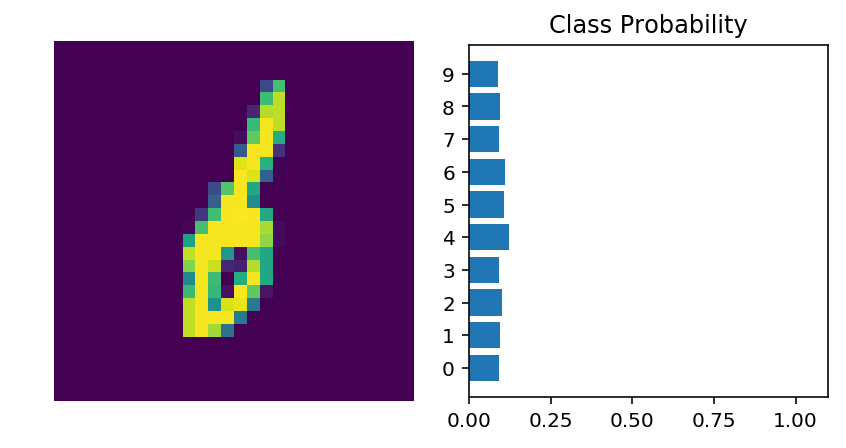

In [22]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# # Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
# # images.resize_(64, 1, 784)
# images.resize_(images.shape[0], 1, 784) 

# print(images.shape)

# # Forward pass through the network
img_idx = 0
# print(images[img_idx,:].shape)
# ps = model.forward(images[img_idx,:])

images.resize_(images.shape[0], 784) 
print(images.shape)
outputs = model.forward(images)

img = images[img_idx]
prob_dist = outputs[img_idx]
helper.view_classify(img.view(1, 28, 28), prob_dist)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

## 3. Pytorch Sequential Model

PyTorch provides `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)) class, which a convenient way to build networks where a input `Tensor` is passed sequentially through layers of operations. When initiating this class we can pass a list of `nn.Module` objects in a particular sequence. The object returned by `nn.Sequential` is itself a `nn.Module` object. When this object is run with an input, it sequentially runs the input through all the `nn.Module` object we passed to it, in the very same order as we passed them.

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


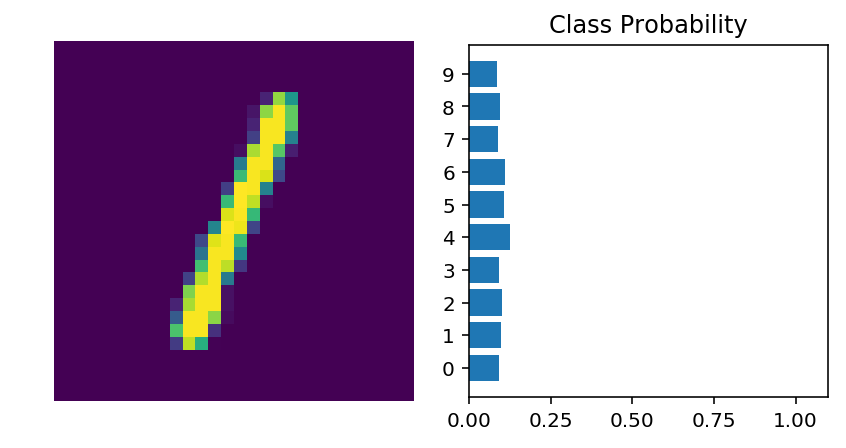

In [16]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

You can also pass in an `OrderedDict` to name the individual layers and operations.

> Note that a dictionary keys must be unique, so _each operation must have a different name_.

In [45]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

## 4. Build Your Neural Network

Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.

**Exercise:** Build a network to classify the MNIST images. The network should:
* Use 3 hidden layers. 
* Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. 
* Use ReLU activation function for each hidden layer, 
* Use softmax on the output layer. 

In [17]:
class FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # define hidden layers
        self.fn1 = nn.Linear(784, 400)
        self.fn2 = nn.Linear(400, 200)
        self.fn3 = nn.Linear(200, 100)
        
        # define output layers
        self.out = nn.Linear(100, 10)
        
    def forward(self, x):
        
        x = self.fn1(x)
        x = F.relu(x)
        x = self.fn2(x)
        x = F.relu(x)
        x = self.fn3(x)
        x = F.relu(x)
        x = self.out(x)
        
        output = F.softmax(x, dim=1)
        return output

ffnn = FFNN()
print(ffnn)

FFNN(
  (fn1): Linear(in_features=784, out_features=400, bias=True)
  (fn2): Linear(in_features=400, out_features=200, bias=True)
  (fn3): Linear(in_features=200, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


torch.Size([1, 784])


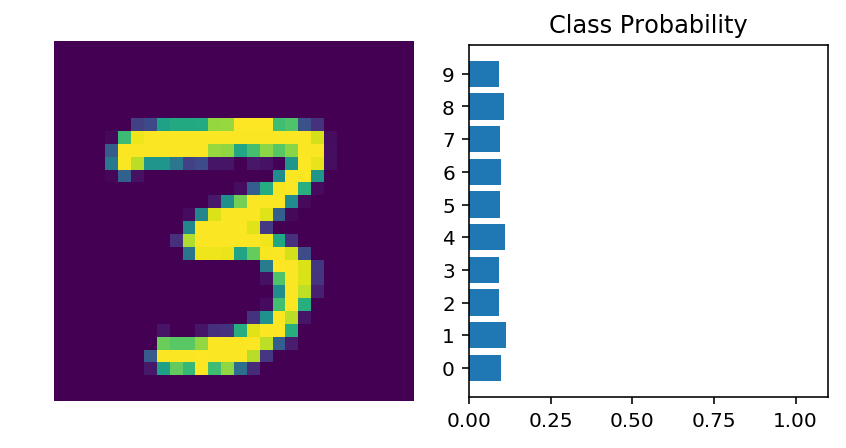

In [23]:
## Run this cell with your model to make sure it works ##
# Forward pass through the network and display output
ffnn = FFNN()
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
single_img = images[0,:]
print(single_img.shape)
ps = ffnn.forward(single_img)
helper.view_classify(images[0].view(1, 28, 28), ps)